<a href="https://colab.research.google.com/github/conker84/cy2py/blob/main/examples/Neo4j_Crime_Investigation_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crime Investigation Dataset with Neo4j and cy2py

This notebook shows how to dive into a the Neo4j crime dataset sandbox.


# Create the sandbox instance

You can easily spin-up a Neo4j sandbox by click [here](https://sandbox.neo4j.com/?usecase=pole&_gl=1*15exsk4*_ga*MTc2OTMwNjEwMy4xNjQ5NDI3MDE0*_ga_DL38Q8KGQC*MTY2MjM2OTA2OS4yMzcuMS4xNjYyMzY5MTg5LjAuMC4w&_ga=2.160268413.1162643613.1662369070-1769306103.1649427014)

After that you'll be redirect in a webpage like this:

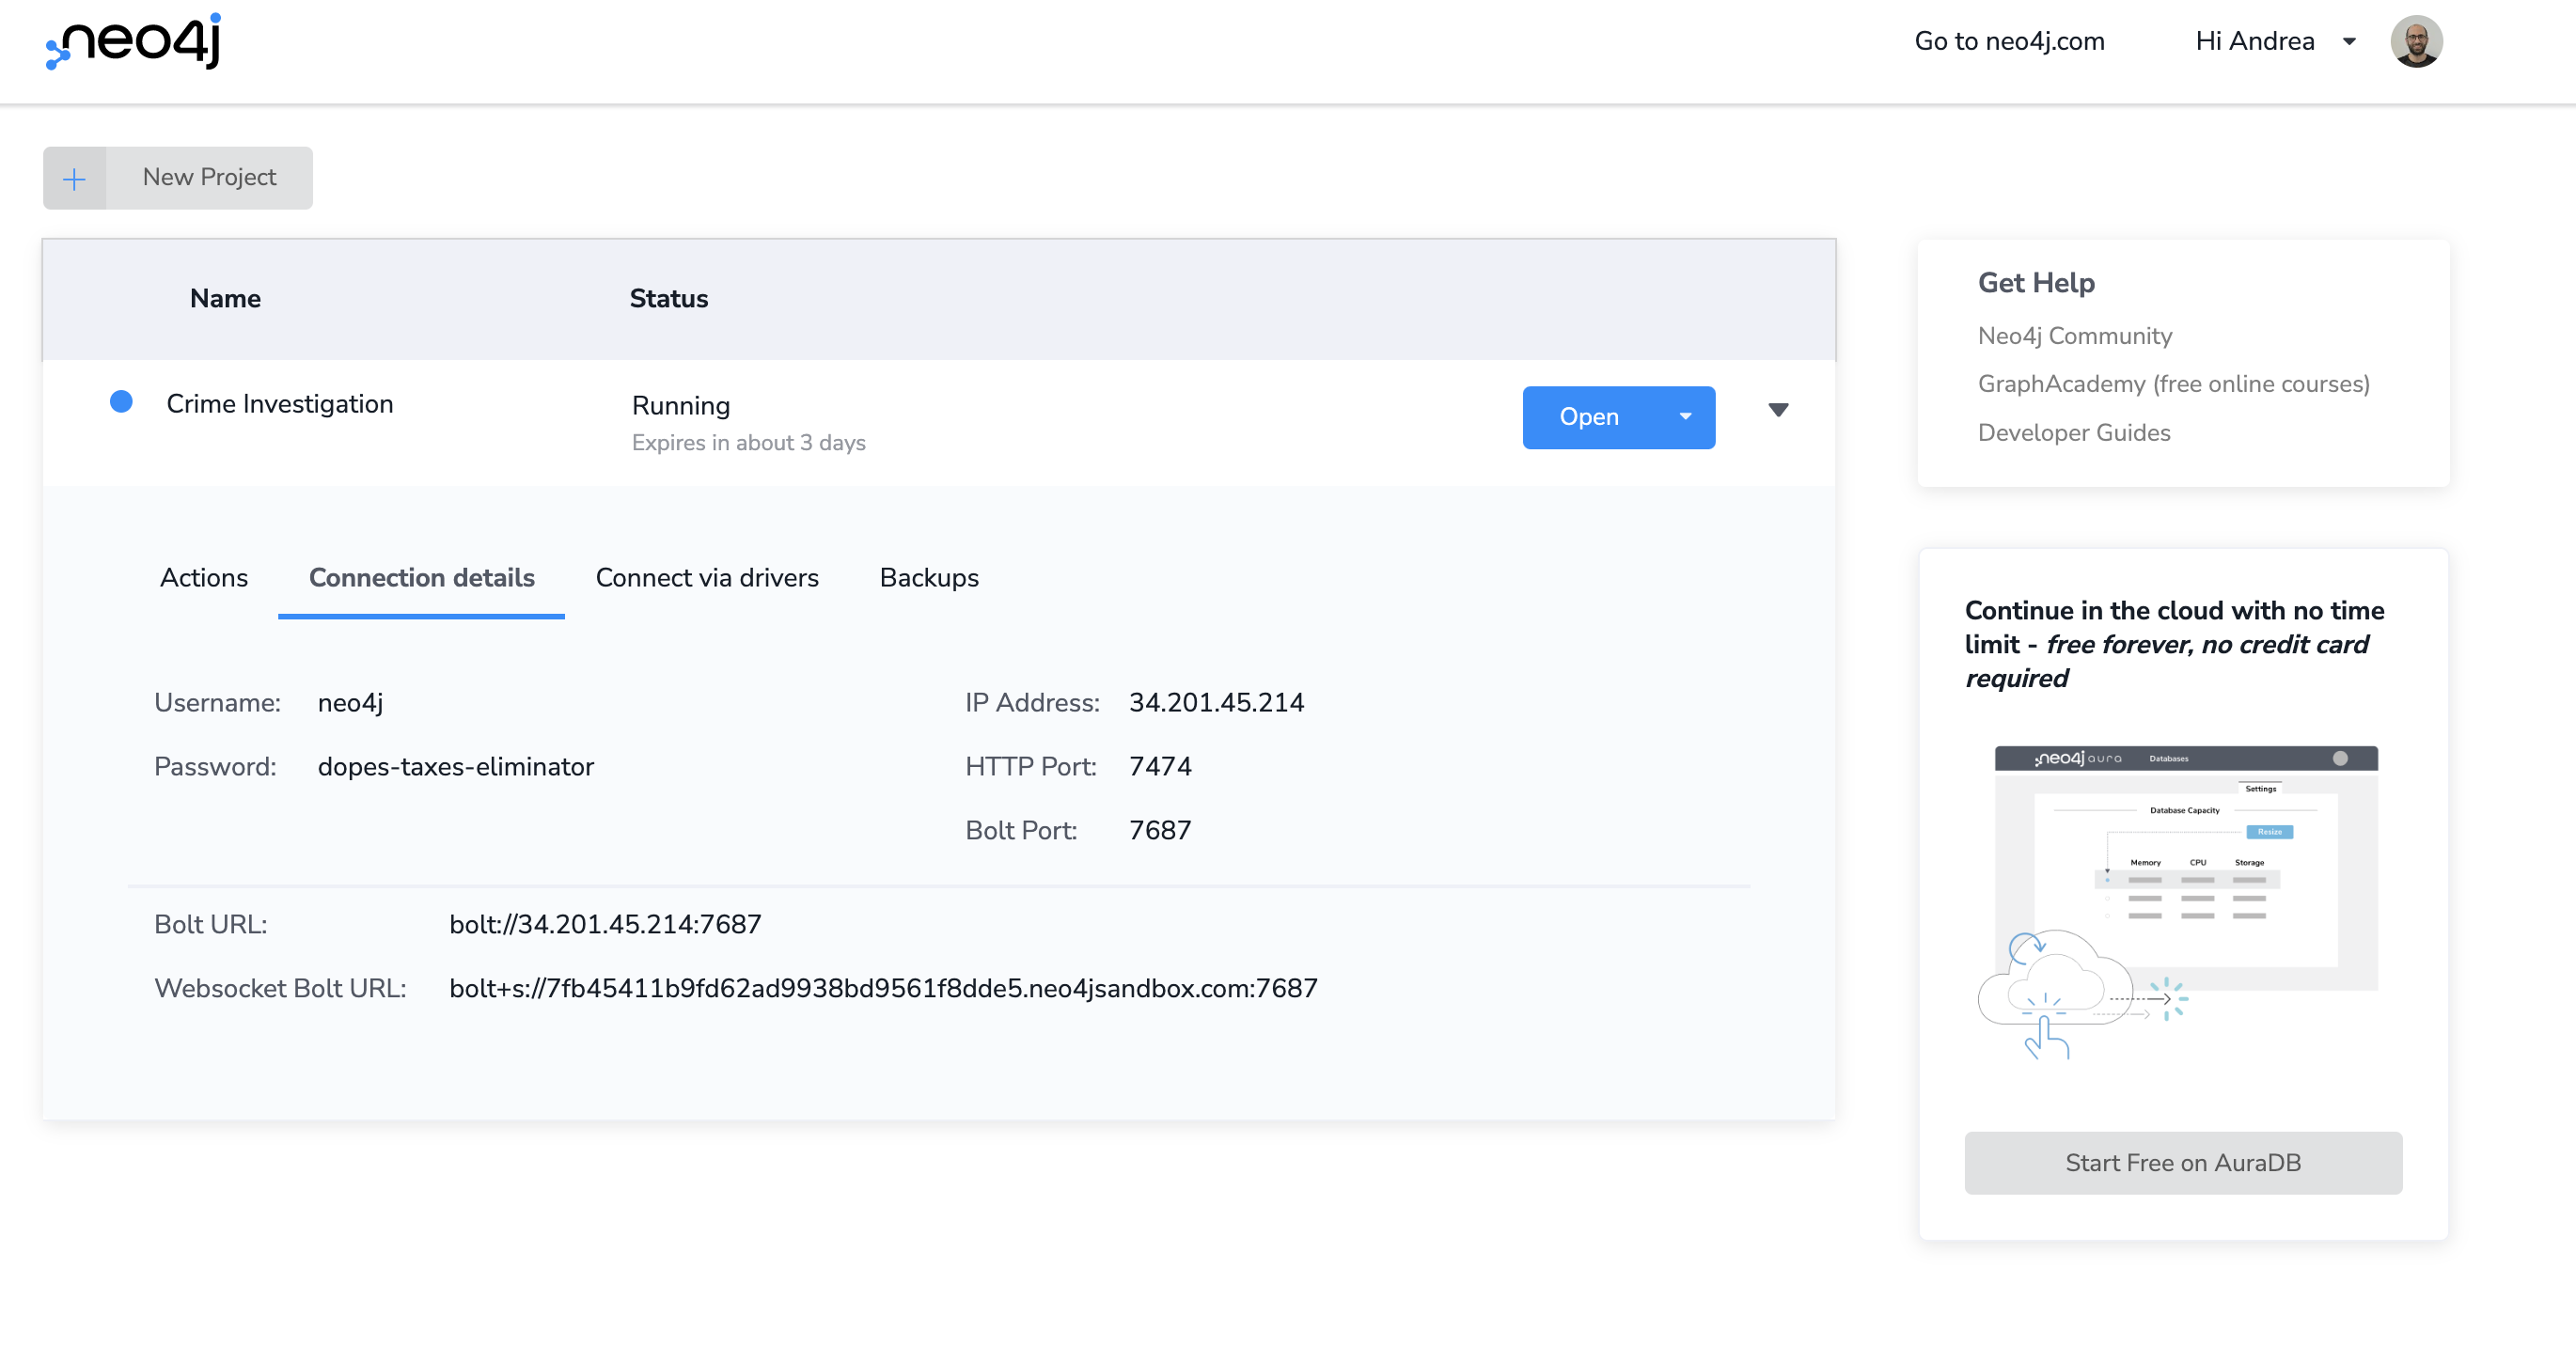 

Please click in the **Connection details tab** and copy your connection parameters into the Python variables below

In [1]:
neo4j_url = ""
neo4j_user = ""
neo4j_pwd = ""

# Install cy2py, a Neo4j Jupyter extension

cy2py is a Neo4j Jupyter extension that allows you to interact with Cypher queries and DataFrame seamlessly.

You can write Cypher queries and get back Dataframe data or visualize the resulting graph directly in the notebook.

Please star it on [GitHub](https://github.com/conker84/cy2py)

In [2]:
!pip install cy2py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 386 kB 5.2 MB/s 
     |████████████████████████████████| 173 kB 39.0 MB/s 
     |████████████████████████████████| 3.6 MB 51.9 MB/s 
     |████████████████████████████████| 1.6 MB 37.2 MB/s 
  Created wheel for cy2py: filename=cy2py-1.1.0-py3-none-any.whl size=8587 sha256=fd8ced61e694fc3c905f65ba93d52c2e59a3572221b814b5c1dc5d6fa53ac5c3
  Stored in directory: /root/.cache/pip/wheels/e6/37/16/4392d3ae82ae0409bce131185a828ea8cc576dfcbdc69b6047
  Created wheel for neo4j: filename=neo4j-5.2.0-py3-none-any.whl size=248023 sha256=09ffba5ad6f1f39552628ed9f2095f31975d99bc1fab1e03a28aef321cd12110
  Stored in directory: /root/.cache/pip/wheels/5a/07/16/4d845d69ef310660c14b7148848c95da3ef3950c7b58daec42
Successfully built cy2py neo4j


In [3]:
%load_ext cy2py

## How you can use it

You can use cy2py in two ways:

* as a line magic, it returns a Python dataframe that you can than manipulate as you wish

* as cell magic that will print a graph or dataframe if the result is tabular

### cy2py example as line magic

In [4]:
%cypher?

In [4]:
my_simple_df = %cypher -u $neo4j_url -us $neo4j_user -pw $neo4j_pwd RETURN 1 AS foo, 'bar' AS bar
my_simple_df

,foo,bar
0,1,bar


### cy2py example as cell magic

As in the previous call (the line magic test) we already passed authentication info, we don't need to to that again. So we just need:

In [6]:
%%cypher
CALL apoc.meta.graph()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'padding': 0, 'nodeSpacing': 10, 'edgeLengthVal': 10, 'anim…

As you noticed the nodes are all with the same color, cy2py allows to attach colors to node labels

In [7]:
colors = {
  ':Person': '#fffb00',
  ':Object': '#00f900',
  ':Location': '#ff2600',
  ':Crime': '#53d5fd'
}

In [8]:
%%cypher -co $colors
CALL apoc.meta.graph()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'padding': 0, 'nodeSpacing': 10, 'edgeLengthVal': 10, 'anim…

# The data model

This notebook will demonstrate how Neo4j can be used with a POLE data model in the context of police and child protection investigations.

The **POLE** data model focuses on four basic types of entities and the relationships between them: **P**ersons, **O**bjects, **L**ocations, and **E**vents.

In [9]:
%%cypher
CALL apoc.meta.graph()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'padding': 0, 'nodeSpacing': 10, 'edgeLengthVal': 10, 'anim…

The POLE data model is a standard approach used in policing, investigative, and security use cases. It can also, however, be applied in other areas. Typical POLE use cases include:

* Policing
* Counter Terrorism
* Border Control / Immigration
* Child Protection / Social Services
* Missing Persons
* Offender Rehabilitation
* Insurance Fraud Investigations

Graphs are a perfect fit for use cases like these, where it is important to be able to work with highly connected data in real time. Using a real-time graph helps investigators to be proactive and prevent crime or other incidents, rather than simply being reactive after an incident has occurred. A POLE graph can also be used to generate insights into patterns of behaviour and incidents, which can inform new approaches and enable more targeted use of limited resources.

Crime data for this demo was downloaded from public sources (http://data.gov.uk), and is freely provided for download with locations defined to the block or street level and crimes defined by month only (i.e. no day or timestamp). This public crime data does not include any sort of information about persons related to crimes, not even as anonymised tokens - it supplies only crime and location data, or in other words only the 'L' and 'E' for the POLE model. This demo uses street crime data for Greater Manchester, UK from August 2017.

# Dive into the data

## The count of total crimes by the type

In [10]:
%%cypher
MATCH (c:Crime)
RETURN c.type AS crime_type, count(c) AS total
ORDER BY count(c) DESC

,crime_type,total
0,Violence and sexual offences,8765
1,Public order,4839
2,Criminal damage and arson,3587
3,Burglary,2807
4,Vehicle crime,2598
5,Other theft,2140
6,Shoplifting,1427
7,Other crime,651
8,Robbery,541
9,Theft from the person,423


## An heat map representation of where the crime occured

In this case we're using [Ploty](https://plotly.com/python/) in order to visualize the heatmap from the DataFrame returned by our query.

In [ ]:
import plotly.express as px
location_query = """
  MATCH (l:Location)<-[:OCCURRED_AT]-(:Crime)
  RETURN l.latitude AS latitude, l.longitude AS longitude, count(l) AS total
"""

crime_locations_df = %cypher -q $location_query

fig = px.density_mapbox(crime_locations_df, lat='latitude', lon='longitude', z='total', radius=10,
                        center=dict(lat=53.51481, lon=-2.407476), zoom=9,
                        mapbox_style="stamen-terrain")
fig.show()

## Shortest path between persons related to crimes

Let’s see if the two Persons - Jack Powell and Raymond Walker - associated with these three Drugs Crimes are somehow connected in the graph. We’ll look for all of the shortest paths between them of 3 or fewer hops along all types of 'KNOWS' relationships. We can ignore the direction of the relationships in this query, as we’re not interested in which direction they point.

In [ ]:
%%cypher
MATCH (c:Crime {last_outcome: 'Under investigation', type: 'Drugs'})-[:INVESTIGATED_BY]->(:Officer {badge_no: '26-5234182'}),
(c)<-[:PARTY_TO]-(p:Person)
WITH COLLECT(p) AS persons
UNWIND persons AS p1
UNWIND persons AS p2
WITH * WHERE id(p1) < id(p2)
MATCH path = allshortestpaths((p1)-[:KNOWS|KNOWS_LW|KNOWS_SN|FAMILY_REL|KNOWS_PHONE*..3]-(p2))
RETURN path

It turns out they are part of what looks like a social group. Two of Raymond’s family relations (his father Phillip and sister Kathleen) know Alan Ward, who is the brother of Jack Powell. Raymond’s father Phillip also lives with Jack’s father Brian. Knowing that Raymond is under investigation for production of cannabis, that Jack is under investigation for two separate charges of possession of cannabis with intent to supply, and that they seem to be part of a social group we can speculate it’s possible that they know each other and that Jack is getting his cannabis from Raymond.

## Vulnerable Persons Investigation

Now we can explore a series of queries to simulate research on 'vulnerable' or 'at risk' individuals in the graph. This might be especially important in a social services or child protection use case. Here we have defined 'vulnerable person' as someone who is not themselves associated to a crime, but who knows many people who are. Run the query below to generate a list of the Top 5 most vulnerable people in the graph.

In [ ]:
import plotly.express as px
vulnerable_people_query = """
  MATCH (p:Person)-[:KNOWS]-(friend)-[:PARTY_TO]->(:Crime)
  WHERE NOT (p:Person)-[:PARTY_TO]->(:Crime)
  RETURN p.name + ' ' + p.surname AS fullName, count(distinct friend) AS dangerousFriends
"""
vulnerable_people_df = %cypher -q $vulnerable_people_query
fig = px.bar(vulnerable_people_df, x='fullName', y='dangerousFriends')
fig.show()


# Extract a Graph into NetworkX and uses its algorithms

This identifies communities or clusters of connectivity in graphs, and might be used in a policing context to identify gangs or other criminal/suspected groups.

In [ ]:
import networkx as nx
import pandas as pd
social_projection_query = """
  MATCH (s:Person)-[r:KNOWS]-(t:Person)
  RETURN *
"""
social_projection_graph = %cypher -q $social_projection_query
social_projection_graph = nx.Graph(social_projection_graph)
triangles = nx.triangles(social_projection_graph)
top_10 = sorted(triangles.items(), key=lambda item: item[1], reverse=True)[0:10]
top_10_df = pd.DataFrame.from_records(top_10, columns=['node_id', 'triangles'])
top_10_df

# Wrap up

This was a simplified demo, and a real POLE model populated with actual police data would be much more complicated and rich. However, this was a good way to explore some POLE data modelling and queries in a semi-real world way.

